# Keypoint Estimation EDA

In [1]:
import os
import sys
import git
import json
import pprint
import numpy as np
import polars as plr
import matplotlib.pyplot as plt

git_repo = git.Repo(os.getcwd(), search_parent_directories=True)
git_root = git_repo.git.rev_parse("--show-toplevel")

sys.path.append(git_root)
from keypoint_estimation.datasets.datamodule import KeypointEstDataModule
from utils.datasets.seed import set_seed

set_seed()

dataset_dir = f"{git_root}/keypoint_estimation/datasets/local"

# print table configs
plr.Config.restore_defaults()
plr.Config.set_tbl_cols(-1)
# plr.Config.set_tbl_rows(1)

polars.config.Config

## Ego4D dataset

In [9]:
ann_dir = os.path.join(dataset_dir, "ego4d/v2/annotations/")

# load manifest data
manifest_path = os.path.join(ann_dir, "manifest.csv")
df_manifest = plr.read_csv(manifest_path)

# load annotation data
train_ann_path = os.path.join(ann_dir, "fho_oscc-pnr_train.json")
val_ann_path = os.path.join(ann_dir, "fho_oscc-pnr_val.json")
test_ann_path = os.path.join(ann_dir, "fho_oscc-pnr_test_unannotated.json")

def load_json_as_df(path):
    return plr.read_ndjson(
        bytes("\n".join(
            [json.dumps(r) for r in json.load(open(path, 'r'))["clips"]]
        ), 'utf-8')
    )

df_train = load_json_as_df(train_ann_path)
df_val = load_json_as_df(val_ann_path)
df_test = load_json_as_df(test_ann_path)

### Meta data analysis

In [17]:
def print_df(df):
    print(
        f"shape: {df.shape}",
        f"schema:\n{pprint.pformat(df.schema)}",
        sep="\n",
        end="\n\n"
    )

print_df(df_manifest)
print_df(df_train)
print_df(df_val)
print_df(df_test)

shape: (9611, 45)
schema:
{'benchmarks': Utf8,
 'canonical_audio_base_denominator': Float64,
 'canonical_audio_base_numerator': Float64,
 'canonical_audio_channel_layout': Utf8,
 'canonical_audio_channel_rate_hz': Float64,
 'canonical_audio_duration_pts': Float64,
 'canonical_audio_duration_sec': Float64,
 'canonical_audio_start_pts': Float64,
 'canonical_audio_start_sec': Float64,
 'canonical_display_height': Int64,
 'canonical_display_width': Int64,
 'canonical_fps': Float64,
 'canonical_is_validated': Boolean,
 'canonical_mp4_duration_sec': Float64,
 'canonical_num_frames': Int64,
 'canonical_s3_location': Utf8,
 'canonical_video_base_denominator': Int64,
 'canonical_video_base_numerator': Int64,
 'canonical_video_duration_pts': Int64,
 'canonical_video_duration_sec': Float64,
 'canonical_video_start_pts': Int64,
 'canonical_video_start_sec': Float64,
 'deid_scrubbed_audio': Boolean,
 'deid_scrubbed_faces': Boolean,
 'device': Utf8,
 'display_resolution_height': Int64,
 'display_res

shape: (1, 2)
┌──────────┬──────────┐
│ positive ┆ negative │
│ ---      ┆ ---      │
│ u32      ┆ u32      │
╞══════════╪══════════╡
│ 74905    ┆ 21044    │
└──────────┴──────────┘


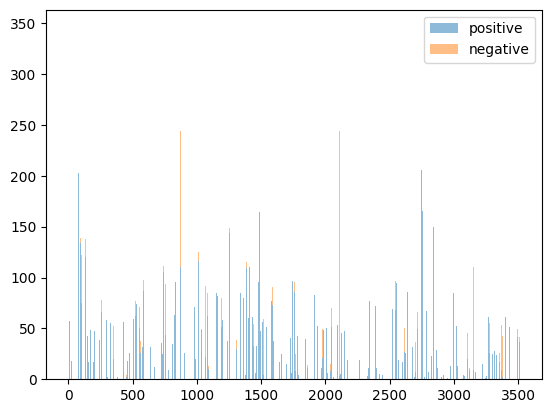

shape: (1, 2)
┌──────────┬──────────┐
│ positive ┆ negative │
│ ---      ┆ ---      │
│ u32      ┆ u32      │
╞══════════╪══════════╡
│ 38621    ┆ 14720    │
└──────────┴──────────┘


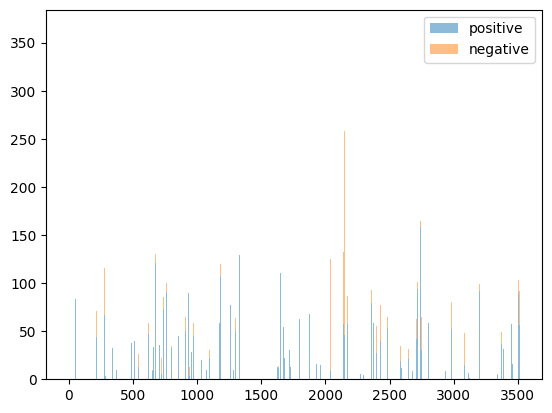

In [13]:
# state change presence
def get_state_chg_count(df):
    return df.select(
        plr.col("clip_id"),
        plr.col("state_change").count().over("clip_id").alias("clip_num"),
        plr.col("state_change").where(plr.col("state_change") == True)\
        .count().over("clip_id").alias("positive"),
        plr.col("state_change").where(plr.col("state_change") == False)\
        .count().over("clip_id").alias("negative"),
    ).unique()

# train data
state_chg_train = get_state_chg_count(df_train)

print(
    state_chg_train.select(
        plr.col("positive").sum(),
        plr.col("negative").sum(),
    )
)

plt.hist(
    state_chg_train.select(
        plr.col("clip_id").cast(plr.Int32),
        plr.col("clip_id").cast(plr.Int32).alias("clip_id2"),
    ),
    weights=state_chg_train.select(
        plr.col("positive"),
        plr.col("negative"),
    ),
    stacked=True,
    bins=5000,
    alpha=0.5,
    label=["positive", "negative"]
)

plt.legend()
plt.show()

# validation data
state_chg_val = get_state_chg_count(df_val)

print(
    state_chg_val.select(
        plr.col("positive").sum(),
        plr.col("negative").sum(),
    )
)

plt.hist(
    state_chg_val.select(
        plr.col("clip_id").cast(plr.Int32),
        plr.col("clip_id").cast(plr.Int32).alias("clip_id2"),
    ),
    weights=state_chg_val.select(
        plr.col("positive"),
        plr.col("negative"),
    ),
    stacked=True,
    bins=5000,
    alpha=0.5,
    label=["positive", "negative"]
)

plt.legend()
plt.show()

plt.clf()
plt.close()

shape: (9, 3)
┌────────────┬────────────────┬────────────────────┐
│ describe   ┆ clip_pnr_frame ┆ clip_pnr_frame_val │
│ ---        ┆ ---            ┆ ---                │
│ str        ┆ f64            ┆ f64                │
╞════════════╪════════════════╪════════════════════╡
│ count      ┆ 74905.0        ┆ 38621.0            │
│ null_count ┆ 0.0            ┆ 0.0                │
│ mean       ┆ 0.48625        ┆ 0.421546           │
│ std        ┆ 0.117063       ┆ 0.13543            │
│ min        ┆ 0.004167       ┆ 0.0                │
│ 25%        ┆ 0.4625         ┆ 0.367647           │
│ 50%        ┆ 0.495833       ┆ 0.429293           │
│ 75%        ┆ 0.529167       ┆ 0.481928           │
│ max        ┆ 0.991667       ┆ 1.0                │
└────────────┴────────────────┴────────────────────┘


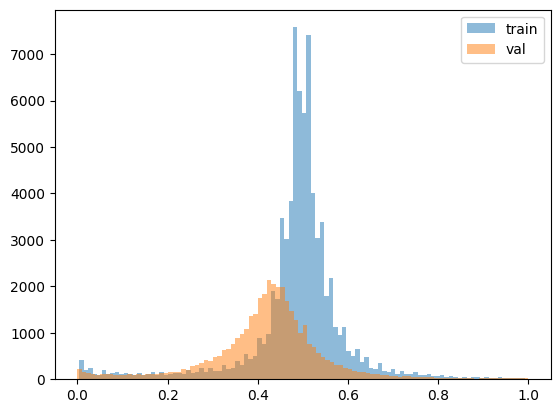

In [21]:
# temporal location of PNR frames (on clip level)
def get_pnr_loc_clip(df):
    return df.select(
        (
            (plr.col("clip_pnr_frame") - plr.col("clip_start_frame")) /\
            (plr.col("clip_end_frame") - plr.col("clip_start_frame"))
        ).where(plr.col("state_change") == True)
    )

pnr_loc_train_clip = get_pnr_loc_clip(df_train)
pnr_loc_val_clip = get_pnr_loc_clip(df_val)

print(
    pnr_loc_train_clip.describe().join(
        pnr_loc_val_clip.describe(),
        on="describe",
        suffix="_val",
    )
)

plt.hist(pnr_loc_train_clip, bins=100, alpha=0.5, label="train")
plt.hist(pnr_loc_val_clip, bins=100, alpha=0.5, label="val")

plt.legend()
plt.show()

plt.clf()
plt.close()

shape: (9, 3)
┌────────────┬──────────────────┬──────────────────────┐
│ describe   ┆ parent_pnr_frame ┆ parent_pnr_frame_val │
│ ---        ┆ ---              ┆ ---                  │
│ str        ┆ f64              ┆ f64                  │
╞════════════╪══════════════════╪══════════════════════╡
│ count      ┆ 74905.0          ┆ 38621.0              │
│ null_count ┆ 0.0              ┆ 0.0                  │
│ mean       ┆ 0.494457         ┆ 0.502876             │
│ std        ┆ 0.291065         ┆ 0.274427             │
│ min        ┆ 0.000772         ┆ 0.000615             │
│ 25%        ┆ 0.232618         ┆ 0.273112             │
│ 50%        ┆ 0.486056         ┆ 0.506598             │
│ 75%        ┆ 0.746691         ┆ 0.729109             │
│ max        ┆ 0.99928          ┆ 0.999276             │
└────────────┴──────────────────┴──────────────────────┘


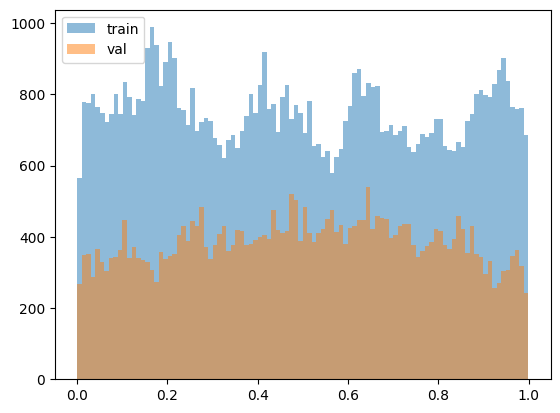

In [22]:
# temporal location of PNR frames (on video level)
def get_pnr_loc_video(df, df_manifest):
    return df.join(
        df_manifest,
        on="video_uid",
    ).select(
        (
            plr.col("parent_pnr_frame") / plr.col("canonical_num_frames")
        ).where(plr.col("state_change") == True)
    )

pnr_loc_train_video = get_pnr_loc_video(df_train, df_manifest)
pnr_loc_val_video = get_pnr_loc_video(df_val, df_manifest)

print(
    pnr_loc_train_video.describe().join(
        pnr_loc_val_video.describe(),
        on="describe",
        suffix="_val",
    )
)

plt.hist(pnr_loc_train_video, bins=100, alpha=0.5, label="train")
plt.hist(pnr_loc_val_video, bins=100, alpha=0.5, label="val")

plt.legend()
plt.show()

plt.clf()
plt.close()

In [85]:
# temporal interval between PNR frames (on video level)
def get_pnr_intvl_video(df, df_manifest):
    return df.join(
        df_manifest,
        on="video_uid",
    ).select(
        "video_uid", "parent_pnr_frame",
    ).drop_nulls().groupby(
        "video_uid",
    ).agg(
        "parent_pnr_frame",
    ).with_columns(
        plr.struct(
            ["parent_pnr_frame"],
        ).apply(
            lambda c: np.diff(sorted(c["parent_pnr_frame"])).tolist(),
        ).alias("diff"),
    ).explode(
        "diff"
    ).filter(
        # same pnr is recorded with different clip_id
        # ignoring diff=0 to get accurate mean
        plr.col("diff") > 0
    ).select("diff")

pnr_intvl_train_video = get_pnr_intvl_video(df_train, df_manifest)
pnr_intvl_val_video = get_pnr_intvl_video(df_val, df_manifest)

print(df_train.join(
        df_manifest,
        on="video_uid",
    ).select(
        "video_uid", "parent_pnr_frame",
    ).drop_nulls().groupby(
        "video_uid",
    ).agg(
        "parent_pnr_frame",
    ).with_columns(
        plr.struct(
            ["parent_pnr_frame"],
        ).apply(
            lambda c: np.diff(sorted(c["parent_pnr_frame"])).tolist(),
        ).alias("diff"),
    ).filter(
        plr.col("video_uid") == "8e58a7b3-43ef-406d-ad5d-901f83418261"
    ).rows()
)

print(
    pnr_intvl_train_video.describe().join(
        pnr_intvl_val_video.describe(),
        on="describe",
        suffix="_val",
    )
)

[('8e58a7b3-43ef-406d-ad5d-901f83418261', [63116, 63498, 63538, 63887, 63956, 64124, 64167, 64167, 64192, 64207, 64225, 64299, 64307, 64324, 64340, 64392, 64514, 64553, 64937, 65204, 65231, 65296, 65889, 65925, 65937, 65953, 65973, 66052, 66289, 66377, 66427, 66507, 66720, 66715, 66777, 66867, 66950, 67203, 67227, 67274, 67427, 67501, 67946, 68038, 68063, 68268, 68282, 68315, 68408, 68577, 69023, 69126, 69180, 69228, 69278, 69500, 69552, 69800, 69850, 70156, 70206, 70412, 70517, 70553, 70801, 70907, 70948, 71000, 71299, 71390, 71416, 71487, 71525, 71645, 71731, 71773, 71940, 198090, 198357, 198619, 198793, 198823, 198849, 198893, 199065, 199095, 199115, 199142, 199154, 199220, 199264, 199345, 199491, 200224, 200265, 200295, 200363, 200560, 200606, 200697, 201090, 201119, 201128, 201168, 201210, 201266, 201396, 201448, 201610, 202223, 202247, 202395, 202424, 202487, 202512, 202536, 202575, 202606, 202654, 202709, 202888, 202907, 202920, 203119, 203163, 203188, 203237, 203445, 203467, 20

## Ego4d dataset w/ reorganization

### Dataset analysis

In [7]:
# segmenting by fixed seconds
segsec_dataset = KeypointEstDataModule(
    dataset_dir=dataset_dir,
    dataset_mode="ego4d",
    batch_size=1,
    transform_mode="display",
    selection="segsec",
    sample_num=16,
)
segsec_dataset.setup()
segsec_train_data = segsec_dataset.train_data
segsec_val_data = segsec_dataset.val_data

segsec_dataset.setup(stage="test")
segsec_test_data = segsec_dataset.test_data

# segmenting by fixed ratio
segratio_dataset = KeypointEstDataModule(
    dataset_dir=dataset_dir,
    dataset_mode="ego4d",
    batch_size=1,
    transform_mode="display",
    selection="segratio",
    sample_num=16,
)
segratio_dataset.setup()
segratio_train_data = segratio_dataset.train_data
segratio_val_data = segratio_dataset.val_data

segratio_dataset.setup(stage="test")
segratio_test_data = segratio_dataset.test_data

shape: (9, 3)
┌────────────┬──────────────────┬──────────────────────┐
│ describe   ┆ parent_pnr_frame ┆ parent_pnr_frame_val │
│ ---        ┆ ---              ┆ ---                  │
│ str        ┆ f64              ┆ f64                  │
╞════════════╪══════════════════╪══════════════════════╡
│ count      ┆ 77296.0          ┆ 23292.0              │
│ null_count ┆ 0.0              ┆ 0.0                  │
│ mean       ┆ 0.498689         ┆ 0.50518              │
│ std        ┆ 0.289936         ┆ 0.290517             │
│ min        ┆ 0.0              ┆ 0.0                  │
│ 25%        ┆ 0.246862         ┆ 0.25523              │
│ 50%        ┆ 0.497908         ┆ 0.51046              │
│ 75%        ┆ 0.748954         ┆ 0.757322             │
│ max        ┆ 1.0              ┆ 1.0                  │
└────────────┴──────────────────┴──────────────────────┘


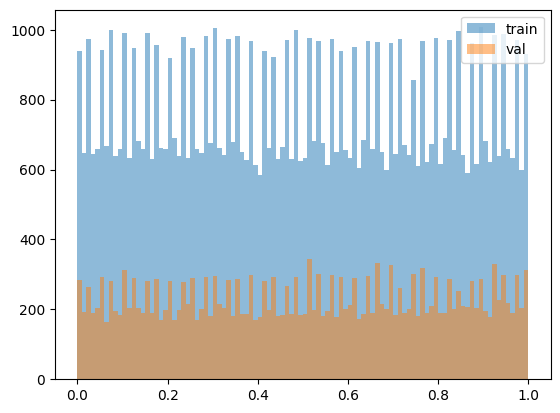

shape: (9, 3)
┌────────────┬──────────────────┬──────────────────────┐
│ describe   ┆ parent_pnr_frame ┆ parent_pnr_frame_val │
│ ---        ┆ ---              ┆ ---                  │
│ str        ┆ f64              ┆ f64                  │
╞════════════╪══════════════════╪══════════════════════╡
│ count      ┆ 76953.0          ┆ 23149.0              │
│ null_count ┆ 0.0              ┆ 0.0                  │
│ mean       ┆ 0.502257         ┆ 0.501121             │
│ std        ┆ 0.288751         ┆ 0.290513             │
│ min        ┆ 0.0              ┆ 0.0                  │
│ 25%        ┆ 0.252688         ┆ 0.25                 │
│ 50%        ┆ 0.503145         ┆ 0.501984             │
│ 75%        ┆ 0.751572         ┆ 0.752929             │
│ max        ┆ 1.0              ┆ 1.0                  │
└────────────┴──────────────────┴──────────────────────┘


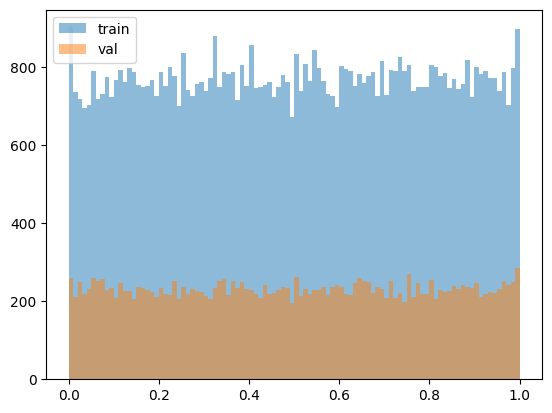

In [20]:
# temporal location of PNR frames (on segment level)
def get_pnr_loc_seg(df):
    return df.explode(
        "parent_pnr_frame"
    ).filter(
        plr.col("parent_pnr_frame").is_not_null() == True
    ).select(
        (plr.col("parent_pnr_frame") - plr.col("segment_start_frame")) /\
        (plr.col("segment_end_frame") - plr.col("segment_start_frame"))
    )

# segsec data
pnr_loc_train_segsec = get_pnr_loc_seg(segsec_train_data.ann_df)
pnr_loc_val_segsec = get_pnr_loc_seg(segsec_val_data.ann_df)

print(
    pnr_loc_train_segsec.describe().join(
        pnr_loc_val_segsec.describe(),
        on="describe",
        suffix="_val",
    )
)

plt.hist(pnr_loc_train_segsec, bins=100, alpha=0.5, label="train")
plt.hist(pnr_loc_val_segsec, bins=100, alpha=0.5, label="val")

plt.legend()
plt.show()

# segratio data
pnr_loc_train_segratio = get_pnr_loc_seg(segratio_train_data.ann_df)
pnr_loc_val_segratio = get_pnr_loc_seg(segratio_val_data.ann_df)

print(
    pnr_loc_train_segratio.describe().join(
        pnr_loc_val_segratio.describe(),
        on="describe",
        suffix="_val",
    )
)

plt.hist(pnr_loc_train_segratio, bins=100, alpha=0.5, label="train")
plt.hist(pnr_loc_val_segratio, bins=100, alpha=0.5, label="val")

plt.legend()
plt.show()

plt.clf()
plt.close()

### Single data analysis

77cc4654-4eec-44c6-af05-dbdf71f9a401


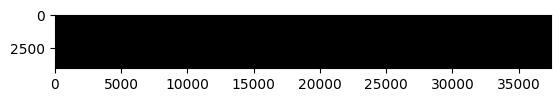

In [8]:
from matplotlib.colors import ListedColormap
from utils.datasets.ego4d.visualize import Visualizer

video_uid = df_manifest["video_uid"][0]
print(video_uid)

visualizer = Visualizer(df_manifest, df_train, df_val)
actions, image = visualizer.visualize_action(video_uid)

image = np.tile(actions.astype(np.uint8), reps=(4000, 1))

cmap = ListedColormap(["black", "red", "green"])
plt.imshow(image, cmap=cmap)
plt.show()

plt.clf()
plt.close()